# First analysis

This notebook shows a simple example of a Crab analysis using the H.E.S.S. DL3 data release 1. It reduces the data to cube datasets and performs a simple 3D model fitting of the Crab nebula.

It uses the high level `Analysis` class to orchestrate data reduction. In its current state, `Analysis` supports the standard analysis cases of joint or stacked 3D and 1D analyses. It is instantiated with an `AnalysisConfig` object that gives access to analysis parameters either directly or via a YAML config file. 

To see what is happening under-the-hood and to get an idea of the internal API, a second notebook performs the same analysis without using the `Analysis` class. 

We will first show how to configure and run a stacked 3D analysis. The structure of the tutorial follows a typical analysis:

- Analysis configuration
- Observation selection
- Data reduction
- Model fitting
- Estimating flux points

Finally we will compare the results against a reference model.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import create_crab_spectral_model

## Analysis configuration

For configuration of the analysis we use the [YAML](https://en.wikipedia.org/wiki/YAML) data format. YAML is a machine readable serialisation format, that is also friendly for humans to read. In this tutorial we will write the configuration file just using Python strings, but of course the file can be created and modified with any text editor of your choice.

Here is what the configuration for our analysis looks like:

In [3]:
config = AnalysisConfig()
# the AnalysisConfig gives access to the various parameters used from logging to reduced dataset geometries
print(config)

AnalysisConfig

    general:
        log:
            level: info
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: null
            lon: null
            lat: null
            radius: null
        obs_time:
            start: null
            stop: null
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir:
                    frame: null
                    lon: null
                    lat: null
                binsize: 0.1 deg
                fov:
                    width: 5.0 deg
                    height: 5.0 deg
                binsize_irf: 0.1 deg
                margin_irf: 0.1 deg
            selection:
                offset_max: 2.5 deg
            axes:
                energy:
                    min: 0.1 Te

### Setting the data to use

We want to use Crab runs from the H.E.S.S. DL3-DR1. We define here the datastore and a cone search of observations pointing with 5 degrees of the Crab nebula.
Parameters can be set directly or as a python dict.

In [4]:
# We define the datastore containing the data
config.observations.datastore = '$GAMMAPY_DATA/hess-dl3-dr1'

# We define the cone search parameters
config.observations.obs_cone.frame = 'icrs'
config.observations.obs_cone.lon = "83.633 deg"
config.observations.obs_cone.lat = "22.014 deg"
config.observations.obs_cone.radius = "5 deg"

# Equivalently we could have set parameters with a python dict
#config.observations.obs_cone = {"frame": "icrs", "lon": "83.633 deg", "lat": "22.014 deg", "radius": "5 deg"}

### Setting the reduced datasets geometry

In [5]:
# We want to perform a 3D analysis
config.datasets.type = "3d"
# We want to stack the data into a single reduced dataset
config.datasets.stack = True

# We fiw the WCS geometry of the datasets
config.datasets.geom.wcs.skydir = {"lon": "83.633 deg", "lat": '22.014 deg', "frame": 'icrs'}
config.datasets.geom.wcs.fov = {"width": "3 deg", "height": "3 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# We now fix the energy axis for the counts map
config.datasets.geom.axes.energy.min = "1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 4

# We now fix the energy axis for the IRF maps (exposure, etc)
config.datasets.geom.axes.energy_true.min = "0.5 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy.nbins = 10

### Setting modeling and fitting parameters
`Analysis` can perform a few modeling and fitting tasks besides data reduction. Parameters have then to be passed to the configuration object.

In [6]:
config.fit.fit_range.min = 1 * u.TeV
config.fit.fit_range.max = 10 * u.TeV
config.flux_points.energy = {"min": "1 TeV", "max": "10 TeV", "nbins": 3}

We're all set. 
But before we go on let's see how to save or import `AnalysisConfig` objects though YAML files.

### Using YAML configuration files

One can export/import the `AnalysisConfig` to/from a YAML file.

In [7]:
config.write("config.yaml", overwrite=True)

In [8]:
config = AnalysisConfig.read("config.yaml")
print(config)

AnalysisConfig

    general:
        log:
            level: info
            filename: null
            filemode: null
            format: null
            datefmt: null
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone:
            frame: icrs
            lon: 83.633 deg
            lat: 22.014 deg
            radius: 5.0 deg
        obs_time:
            start: null
            stop: null
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir:
                    frame: icrs
                    lon: 83.633 deg
                    lat: 22.014 deg
                binsize: 0.02 deg
                fov:
                    width: 3.0 deg
                    height: 3.0 deg
                binsize_irf: 0.1 deg
                margin_irf: 0.1 deg
            selection:
                offset_max: 2.5 deg
            axes:
                energy:
   

## Running the analysis

We first create an `~gammapy.analysis.Analysis` object from our configuration.

In [9]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


###  Observation selection

We can directly select and load the observations from disk using `~gammapy.analysis.Analysis.get_observations()`:

In [10]:
analysis.get_observations()

Fetching observations.
Number of selected observations: 4


The observations are now available on the `Analysis` object. The selection corresponds to the following ids:

In [11]:
analysis.observations.ids

['23592', '23523', '23526', '23559']

Now we can access and inspect individual observations by accessing with the observation id:

In [12]:
print(analysis.observations["23592"])

Info for OBS_ID = 23592
- Start time: 53347.91
- Pointing pos: RA 82.01 deg / Dec 22.01 deg
- Observation duration: 1686.0 s
- Dead-time fraction: 6.212 %



And also show a few overview plots using the `.peek()` method:

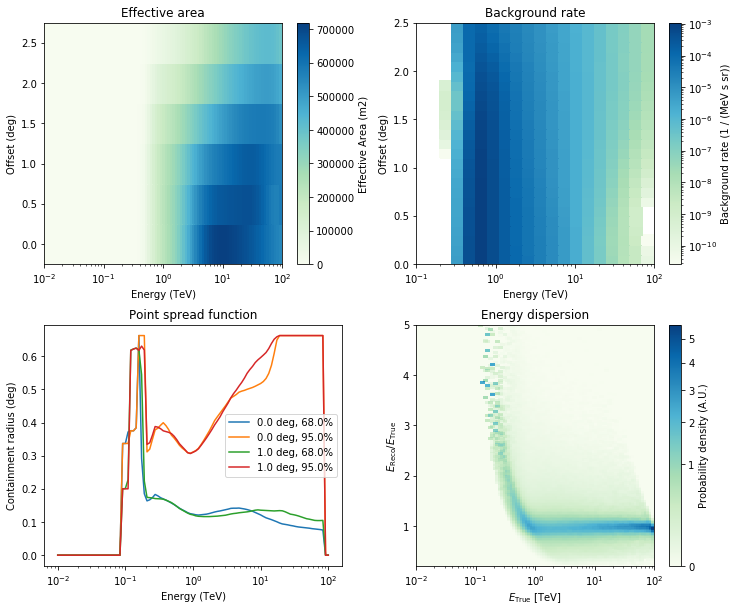

In [13]:
analysis.observations["23592"].peek()

## Data reduction

Now we proceed to the data reduction. In the config file we have chosen a WCS map geometry, energy axis and decided to stack the maps. We can run the reduction using `.get_datasets()`:

In [14]:
%%time
analysis.get_datasets()

Creating geometry.
Creating datasets.
Processing observation 23592
Processing observation 23523
Processing observation 23526
Processing observation 23559


CPU times: user 7.72 s, sys: 2.36 s, total: 10.1 s
Wall time: 10.5 s


As we have chosen to stack the data, there is finally one dataset contained:

In [15]:
print(analysis.datasets)

Datasets
--------
idx=0, id='0x11f80b208', name='stacked'



We can print the dataset as well:

In [16]:
print(analysis.datasets["stacked"])

MapDataset

    Name                            : stacked 

    Total counts                    : 4265 
    Total predicted counts          : 3957.24
    Total background counts         : 3957.24

    Exposure min                    : 1.06e+08 m2 s
    Exposure max                    : 3.53e+09 m2 s

    Number of total bins            : 225000 
    Number of fit bins              : 225000 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : 40479.02

    Number of models                : 0 
    Number of parameters            : 3
    Number of free parameters       : 1

    Component 0: 
        Name                        : background
        Type                        : BackgroundModel
        Parameters:
        




As you can see the dataset comes with a predefined background model out of the data reduction, but no source model has been set yet.

The counts, exposure and background model maps are directly available on the dataset and can be printed and plotted:

In [17]:
counts = analysis.datasets["stacked"].counts

In [18]:
print(counts)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (150, 150, 10)
	ndim  : 3
	unit  : 
	dtype : float32



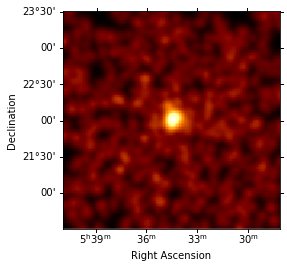

In [19]:
counts.smooth("0.05 deg").plot_interactive()

## Model fitting

Now we define a model to be fitted to the dataset:

In [20]:
model_config = """
components:
- name: crab
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.63
      unit: deg
    - name: lat_0 
      value: 22.14    
      unit: deg
  spectral:
    type: PowerLawSpectralModel
    parameters:
    - name: amplitude      
      value: 1.0e-12
      unit: cm-2 s-1 TeV-1
    - name: index
      value: 2.0
      unit: ''
    - name: reference
      value: 1.0
      unit: TeV
      frozen: true
"""

Now we set the model on the analysis object:

In [21]:
analysis.set_model(model_config)

Reading model.
SkyModels

Component 0: SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 8.363e+01   nan            deg        nan       nan  False
    lat_0 2.214e+01   nan            deg -9.000e+01 9.000e+01  False
    index 2.000e+00   nan                       nan       nan  False
amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True

	




In [22]:
print(analysis.model)

SkyModels

Component 0: SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 8.363e+01   nan            deg        nan       nan  False
    lat_0 2.214e+01   nan            deg -9.000e+01 9.000e+01  False
    index 2.000e+00   nan                       nan       nan  False
amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True

	




In [23]:
print(analysis.model["crab"])

SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 8.363e+01   nan            deg        nan       nan  False
    lat_0 2.214e+01   nan            deg -9.000e+01 9.000e+01  False
    index 2.000e+00   nan                       nan       nan  False
amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True


Finally we run the fit:

In [24]:
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 303
	total stat : 38888.39



In [25]:
print(analysis.fit_result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 303
	total stat : 38888.39



This is how we can write the model back to file again:

In [26]:
analysis.model.to_yaml("model-best-fit.yaml")

In [27]:
!cat model-best-fit.yaml

components:
- name: crab
  type: SkyModel
  spectral:
    type: PowerLawSpectralModel
    parameters:
    - name: index
      value: 2.595413976544358
      unit: ''
      min: .nan
      max: .nan
      frozen: false
    - name: amplitude
      value: 4.775655323151531e-11
      unit: cm-2 s-1 TeV-1
      min: .nan
      max: .nan
      frozen: false
    - name: reference
      value: 1.0
      unit: TeV
      min: .nan
      max: .nan
      frozen: true
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.61908338832292
      unit: deg
      min: .nan
      max: .nan
      frozen: false
    - name: lat_0
      value: 22.024656745949418
      unit: deg
      min: -90.0
      max: 90.0
      frozen: false


### Inspecting residuals

For any fit it is usefull to inspect the residual images. We have a few option on the dataset object to handle this. First we can use `.plot_residuals()` to plot a residual image, summed over all energies: 

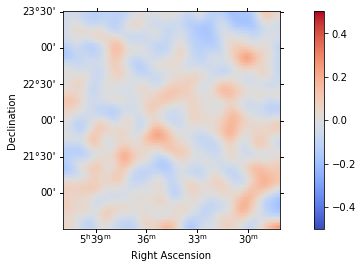

In [28]:
analysis.datasets["stacked"].plot_residuals(
    method="diff/sqrt(model)", vmin=-0.5, vmax=0.5
);

In addition we can aslo specify a region in the map to show the spectral residuals:

In [29]:
region = CircleSkyRegion(
    center=SkyCoord("83.63 deg", "22.14 deg"), radius=0.5 * u.deg
)

NameError: name 'CircleSkyRegion' is not defined

In [ ]:
analysis.datasets["stacked"].plot_residuals(
    region=region, method="diff/sqrt(model)", vmin=-0.5, vmax=0.5
);

We can also directly access the `.residuals()` to get a map, that we can plot interactively:

In [ ]:
residuals = analysis.datasets["stacked"].residuals(method="diff")
residuals.smooth("0.08 deg").plot_interactive(
    cmap="coolwarm", vmin=-0.1, vmax=0.1, stretch="linear", add_cbar=True
)

### Inspecting fit statistic profiles

To check the quality of the fit it is also useful to plot fit statistic profiles for specific parameters.
For this we use `~gammapy.modeling.Fit.stat_profile()`.

In [ ]:
profile = analysis.fit.stat_profile(parameter="lon_0")

For a good fit and error estimate the profile should be parabolic, if we plot it:

In [ ]:
total_stat = analysis.fit_result.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel("Lon (deg)")
plt.ylabel("Delta TS")

### Flux points

In [ ]:
analysis.get_flux_points(source="crab")

In [ ]:
plt.figure(figsize=(8, 5))
ax_sed, ax_residuals = analysis.flux_points.peek()
crab_spectrum = create_crab_spectral_model("hess_pl")
crab_spectrum.plot(
    ax=ax_sed,
    energy_range=[1, 10] * u.TeV,
    energy_power=2,
    flux_unit="erg-1 cm-2 s-1",
)

## Exercises

- Run a spectral analysis using reflected regions without stacking the datasets. You can use `AnalysisConfig.from_template("1d")` to get an example configuration file. Add the resulting flux points to the SED plotted above. 
